In [1]:
import os
import sys
import yaml

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

import logging
import datetime
from pathlib import Path

import torch.utils.data
import torch.nn.functional as F

dname = os.path.abspath('')
module_dir = os.path.abspath("{}/../deeplio".format(dname))
content_dir = os.path.abspath("{}/..".format(dname))
sys.path.append(dname)
sys.path.append(module_dir)
sys.path.append(content_dir)

# change dir to project's root
%cd $content_dir 

/home/ajava/Projects/DeepLIO


In [2]:
from deeplio.common.logger import PyLogger, get_app_logger
from deeplio.datasets import Kitti, deeplio_collate
from deeplio.models.misc import PostProcessSiameseData

# Read configurations
CONFIG_PATH = "{}/config.yaml".format(content_dir)
with open(CONFIG_PATH) as f:
    cfg = yaml.safe_load(f)
    
# extracting infos from config file
ds_cfg = cfg['datasets']
kitti_config = ds_cfg['kitti']
seq_size = ds_cfg['sequence-size']
root_path_sync = kitti_config['root-path-sync']
root_path_unsync = kitti_config['root-path-unsync']

# create directoy to save images
OUTPUT_PATH = "{}/outputs/images".format(content_dir)
Path(OUTPUT_PATH).mkdir(parents=True, exist_ok=True)

# Dataset class needs a global logger, so creat it here
# TODO: Remove dependecy of dataset to global logger, so it can have its own
flog_name = "{}/{}_{}.log".format(OUTPUT_PATH, "Dataset-Visualization", datetime.datetime.now().strftime("%Y%m%d_%H%M%S"))
get_app_logger(filename=flog_name, level=logging.INFO)
    
# create dataset
batch_size = 1
kitti_dataset = Kitti(config=cfg, transform=None, ds_type='train')
post_processor = PostProcessSiameseData(seq_size=seq_size, batch_size=batch_size)
print("Length of dataset is {}".format(len(kitti_dataset)))

# channel settings
CHANNEL_NAMES = ['x', 'y', 'z', 'depth', 'remission']
num_channels = len(CHANNEL_NAMES)
viridis = cm.get_cmap('viridis', 512)
gray = cm.get_cmap('gray', 1024)
jet = cm.get_cmap('jet', 1024)
CHANNEL_CMAP = [jet, jet, jet, jet, jet, gray]

Length of dataset is 20805


In [3]:
data_index = 10

print("Reading one image sample (index={}).".format(data_index))

# get an sample image
dataset, indices = kitti_dataset.get_dataset_and_index(data_index)
data = kitti_dataset.__getitem__(data_index)
data = deeplio_collate([data])
imgs_0, imgs_1, imgs_untrans_0, imgs_untrans_1, imus, gts_local, gts_global = post_processor(data)

print("Raw image shape:{}".format(imgs_untrans_0.shape))
print("Normalized image shape:{}".format(imgs_0.shape))

Reading one image sample (index=10).
Raw image shape:torch.Size([1, 5, 64, 1800])
Normalized image shape:torch.Size([1, 2, 64, 1792])


# Visualizing Raw Images

Image shape:  (64, 1800, 5)


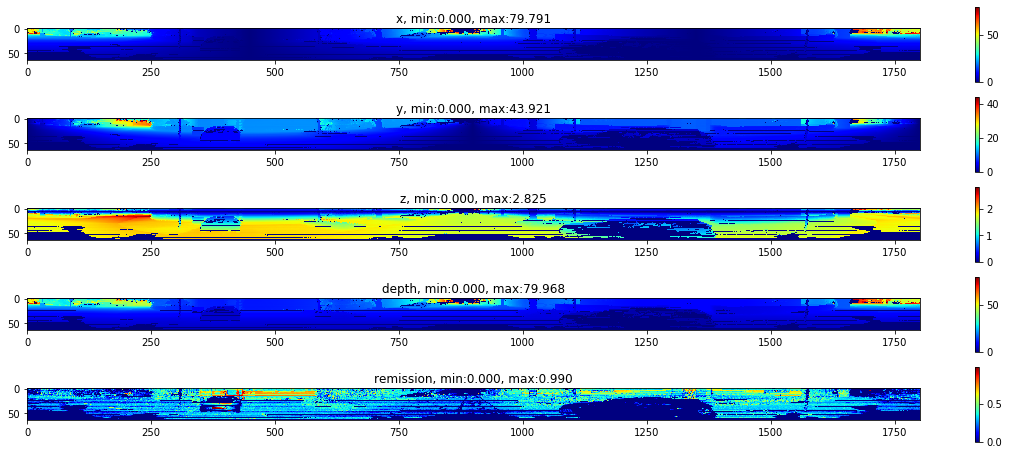

In [4]:
# convert negativ x, y, z coord. to postive
im = np.abs(imgs_untrans_0[0].numpy().transpose(1, 2, 0))
#im = imgs_untrans_0[0].numpy().transpose(1, 2, 0)

print("Image shape: ", im.shape)

fig, axes = plt.subplots(num_channels, 1, figsize=(20, 8))
for i in range(num_channels):
    ax = axes[i]
    img = im[:, :, i]
    ax.imshow(img, cmap=CHANNEL_CMAP[i])
    ax.set_title("{}, min:{:.3f}, max:{:.3f}".format(CHANNEL_NAMES[i], img.min(), img.max()))
    psm = ax.pcolormesh(img, cmap=CHANNEL_CMAP[i], rasterized=True, vmin=img.min(), vmax=img.max())
    fig.colorbar(psm, ax=ax)
    
fig.savefig("{}/kitti_raw_{}_{}.png".format(OUTPUT_PATH, dataset.date, dataset.drive, indices[0]))

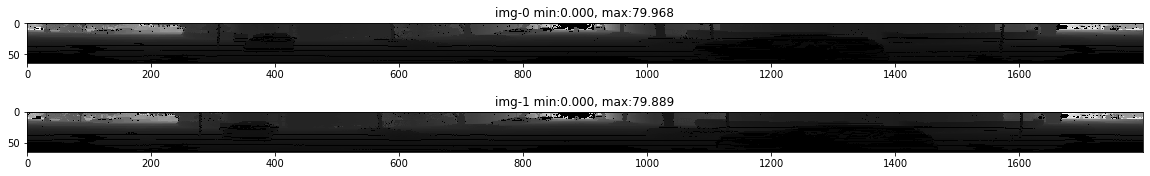

In [5]:
# get an sample image
im_0 = imgs_untrans_0[0].squeeze().numpy().transpose(1, 2, 0)
# get an sample image
im_1 = imgs_untrans_1[0].squeeze().numpy().transpose(1, 2, 0)


imgs = [im_0, im_1]
fig, axes = plt.subplots(2, 1, figsize=(20, 3))
for i in range(2):
    ax = axes[i]
    img = imgs[i][:, :, 3]
    ax.imshow(img, cmap='gray')
    ax.set_title("img-{} min:{:.3f}, max:{:.3f}".format(i, img.min(), img.max()))


# Visualizing Image Gradients

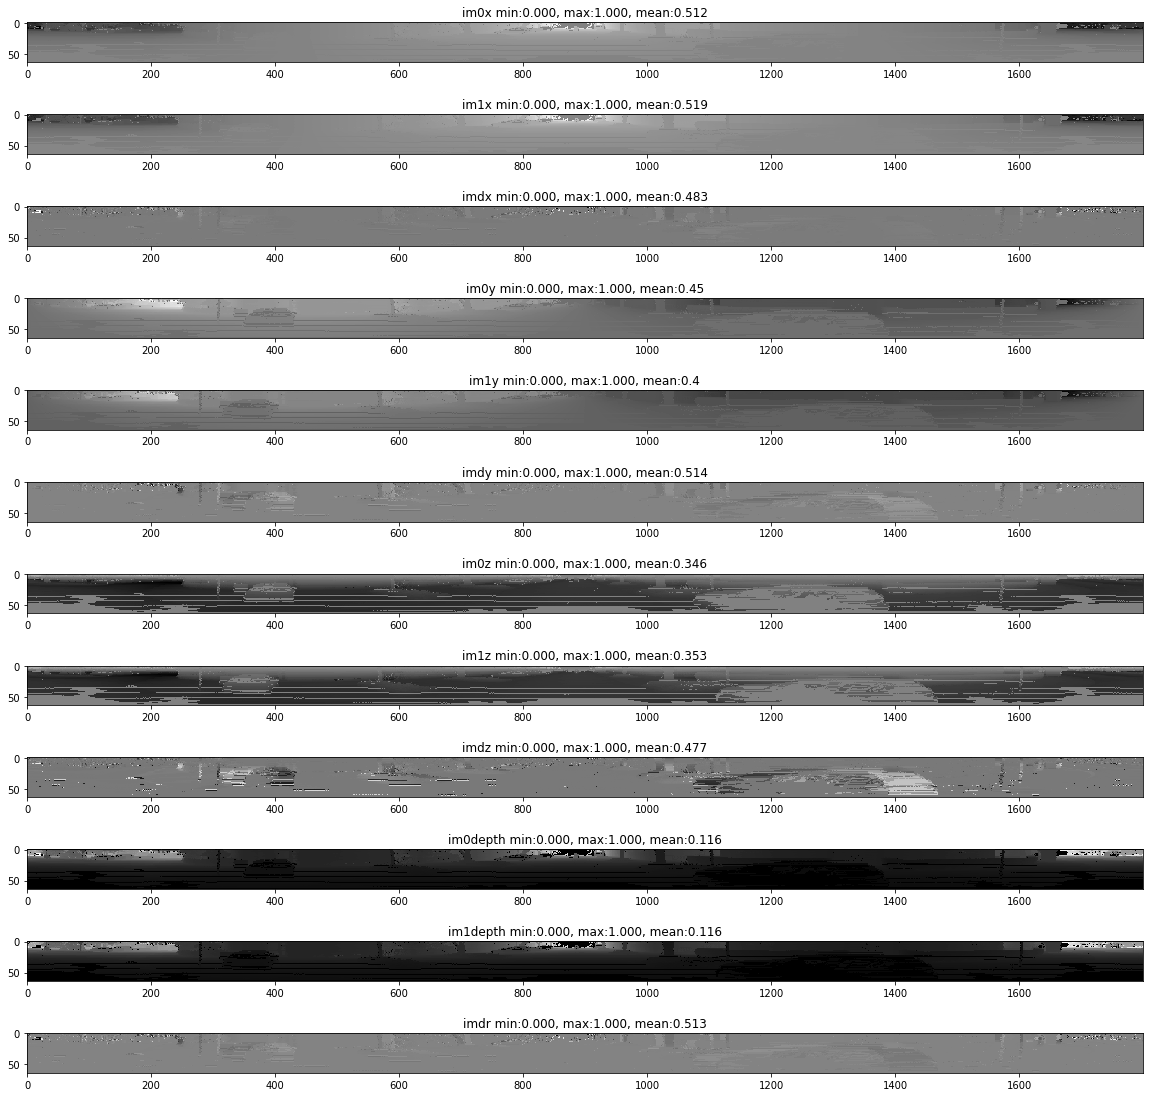

In [6]:
def normalize_image(im):
    return (im - im.min()) / (im.max() - im.min())

im0x = im_0[:, :, 0]
im0y = im_0[:, :, 1]
im0z = im_0[:, :, 2]
im0depth = im_0[:, :, 3]

im1x = im_1[:, :, 0]
im1y = im_1[:, :, 1]
im1z = im_1[:, :, 2]
im1depth = im_1[:, :, 3]

im_dx = im1x - im0x
im_dy = im1y - im0y
im_dz = im1z - im0z
im_dr = im1depth - im0depth

imgs = {'im0x': im0x, 'im1x': im1x, 'imdx': im_dx, 'im0y': im0y, 'im1y':im1y, 
        'imdy': im_dy, 'im0z': im0z, 'im1z': im1z, 'imdz': im_dz, 'im0depth': 
        im0depth, 'im1depth': im1depth, 'imdr': im_dr}

fig, axes = plt.subplots(len(imgs), 1, figsize=(20, 20))
for i, (k, img) in enumerate(imgs.items()):
    ax = axes[i]
    img = normalize_image(img)
    ax.imshow(img, cmap='gray')
    ax.set_title("{} min:{:.3f}, max:{:.3f}, mean:{:.3}".format(k, img.min(), img.max(), img.mean()))

In [7]:
### 3D plotting

import open3d as o3d

from deeplio.common.utils import *

imgs_untrans_0 = imgs_untrans_1.numpy()
im = imgs_untrans_0[0].transpose(1, 2, 0)

pcd = convert_velo_img_to_o3d(im)
o3d.visualization.draw_geometries([pcd])

# Visualizing Normalized Data

Image shape:  (2, 64, 1792)


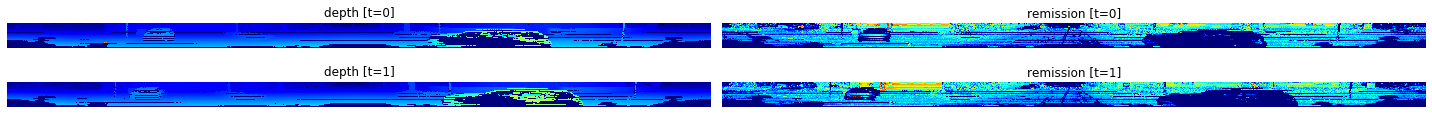

In [8]:
# convert negativ x, y, z coord. to postive
im_0 = imgs_0[0].numpy()
im_1 = imgs_1[0].numpy()

print("Image shape: ", im_0.shape)

CHANNEL_NAMES = ['depth', 'remission']
num_channels = len(CHANNEL_NAMES)

ims = [im_0, im_1]

fig, axes = plt.subplots(2, num_channels, figsize=(20, 2))
for i in range(len(ims)):
    im = ims[i]
    axes[i, 0].imshow(im[0], cmap=CHANNEL_CMAP[i], label='depth [t={}]'.format(i))
    axes[i, 0].set_title('depth [t={}]'.format(i))
    axes[i, 0].axis('off')
    axes[i, 1].imshow(im[1], cmap=CHANNEL_CMAP[i], label='remission [t={}]'.format(i))
    axes[i, 1].set_title('remission [t={}]'.format(i))
    axes[i, 1].axis('off')
    
fig.tight_layout()
fig.savefig("{}/kitti_normalized_{}_{}.png".format(OUTPUT_PATH, dataset.date, dataset.drive, indices[0]), dpi=600)

# Average Transformation of the Kitti Dataset 

In [9]:
import logging
import datetime
from pathlib import Path

import torch.utils.data
import torch.nn.functional as F

from deeplio.common.logger import PyLogger, get_app_logger
from deeplio.datasets import Kitti, deeplio_collate
from deeplio.models.misc import PostProcessSiameseData  

OUTPUT_PATH = "{}/outputs/kittt_avg_trans".format(content_dir)

# create directoy to save images
Path(OUTPUT_PATH).mkdir(parents=True, exist_ok=True)

# Dataset class needs a global logger, so creat it here
# TODO: Remove dependecy of dataset to global logger, so it can have its own
flog_name = "{}/{}_{}.log".format(OUTPUT_PATH, "Kitt-Avg-Trans", datetime.datetime.now().strftime("%Y%m%d_%H%M%S"))
get_app_logger(filename=flog_name, level=logging.INFO)
    
# create dataset andataloader
kitti_dataset = Kitti(config=cfg, transform=None, ds_type='train')
dataloader = torch.utils.data.DataLoader(kitti_dataset, batch_size=batch_size,
                                       num_workers=num_workers,
                                       shuffle=True,
                                       collate_fn = deeplio_collate)

post_processor = PostProcessSiameseData(seq_size=seq_size, batch_size=batch_size, shuffle=True)

print("Length of dataset is {}".format(len(dataloader)))

NameError: name 'num_workers' is not defined

In [3]:
from deeplio.common.spatial import rotation_matrix_to_quaternion, quaternion_to_angle_axis

from tqdm import tqdm

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

pbar = tqdm(total=len(dataloader))

x_avg = AverageMeter('x')
q_avg = AverageMeter('q')

# Iterate through datset and save images
for idx, data in enumerate(dataloader):
    # skip invalid data without ground-truth
    if not torch.all(data['valid']):
        pbar.update(1)
        #print("[{}] Invalid!".format(idx))
        continue
        
    metas = data['metas'][0]
    index = metas['index'][0]
    date = metas['date'][0]
    drive = metas['drive'][0]

    imgs_0, imgs_1,  imgs_untrans_0, imgs_untrans_1, gts, imus = post_processor(data)
    
    # prepare ground truth tranlational and rotational part
    gt_pos = gts[:, :3, 3].contiguous()
    gt_rot = rotation_matrix_to_quaternion(gts[:, :3, :3].contiguous())
    
    x_avg.update(gt_pos.mean(dim=0).numpy()) 
    q_avg.update(gt_rot.mean(dim=0).numpy())    
    
    pbar.update(1)
    #if idx % 100 == 0:
    #    print("{} x-avg: {}, q-avg: {}".format(idx, x_avg.avg, q_avg.avg))
print("x-avg: {}, q-avg: {}".format(x_avg.avg, q_avg.avg))


100%|█████████▉| 15652/15659 [04:47<00:00, 55.36it/s]

x-avg: [1.4350199e+00 6.2639872e-04 1.3253570e-02], q-avg: [-6.2973281e-06  5.3813543e-05  3.3050732e-04  9.9992609e-01]


100%|██████████| 15659/15659 [05:00<00:00, 55.36it/s]

# Visualiziing Ground-Truth Trajectories of KITTI

In [62]:
sequences = ['00', '01', '02', '04', '05', '06', '07', '08']
GTs = [np.dstack(ds.oxts_sync[:, 1]) for  ds in kitti_dataset.datasets]

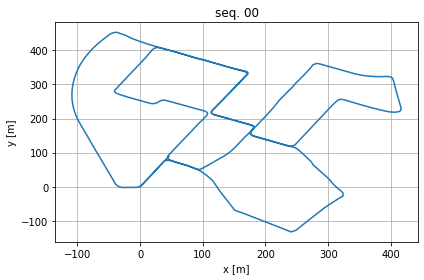

(4, 4, 4544)


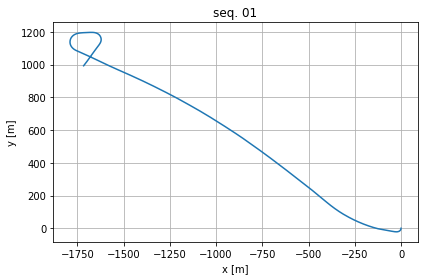

(4, 4, 1170)


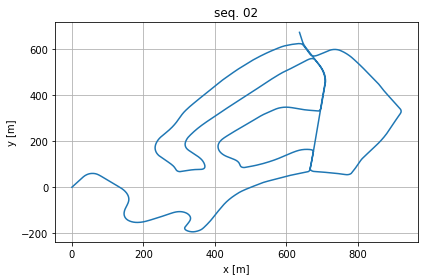

(4, 4, 4663)


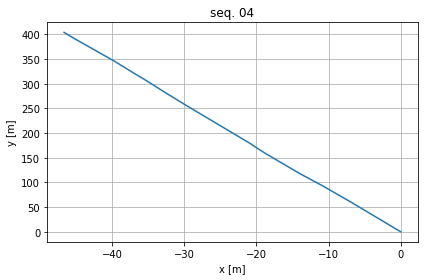

(4, 4, 279)


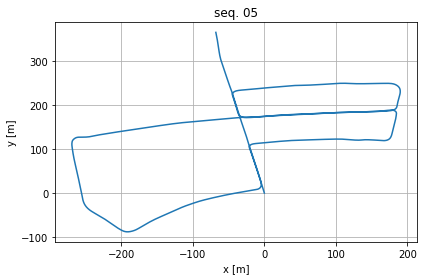

(4, 4, 2762)


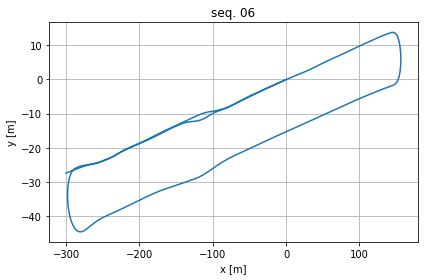

(4, 4, 1104)


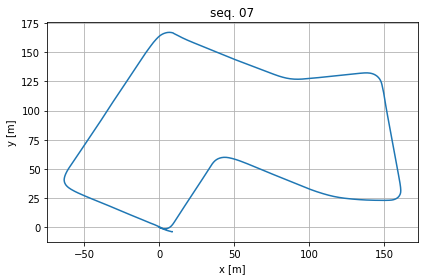

(4, 4, 1106)


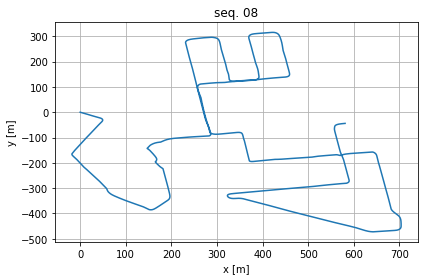

(4, 4, 5177)


In [63]:
for i, gt in enumerate(GTs):
    fig, ax = plt.subplots(1, 1)
    ax.plot(gt[0, 3, :], gt[1, 3, :])
    ax.grid('true')
    ax.set_title('seq. {}'.format(sequences[i]))
    ax.set_xlabel('x [m]')
    ax.set_ylabel('y [m]')    
    fig.tight_layout()
    fig.savefig("{}/kitti_seq_{}.png".format(OUTPUT_PATH, sequences[i]))    
    plt.show()
    print(gt.shape)